In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
import pandas as pd
import re

from utils import *

It is not easy for the CNN to deal with 38% of images belonging to the new_whale class, given both how imbalanced this makes the dataset and also because of the variability within the class. 

One way to address this would be to train a model with a sigmoid output layer. We could then assume no prediction to be background class. Or find some threshold at which we should be predicting the background class based on results on the validation set. Training on over 5k classes with a sigmoid output layer, with only a single positive label per example, might be tough though.

In a sense, we keep bumping into not being able to frame the problem so that it would be easy for our NN to solve. Hopefully with more complex approaches we will be able to address some of the concerns.

For the time being, softmax it is, with the background class being completely skipped.

## A look at the data

In [2]:
df = pd.read_csv('data/train.csv')
df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [3]:
im_count = df[df.Id != 'new_whale'].Id.value_counts()

In [4]:
im_count[(im_count > 1)].count(), (im_count > 1).mean()

(2931, 0.5857314148681055)

Out of 5004 known whales, 58% appear in more than a single image. That doesn't seem too bad. Let's take a look.

In [5]:
def plot_whale_sightings(whale_id, figsize=(10,10)):
    paths = [f'data/train/{fn}' for fn in df[df.Id == whale_id].Image.values]
    ary = np.stack(np.asarray(PIL.Image.open(path).resize((128,128)).convert('RGB')) for path in paths)
    plt.figure(figsize=figsize)
    plt.imshow(montage(ary, multichannel=True))

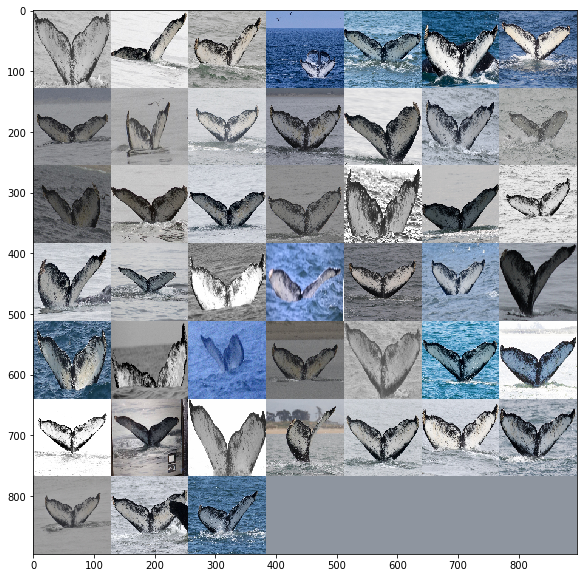

In [6]:
plot_whale_sightings('w_789c969')

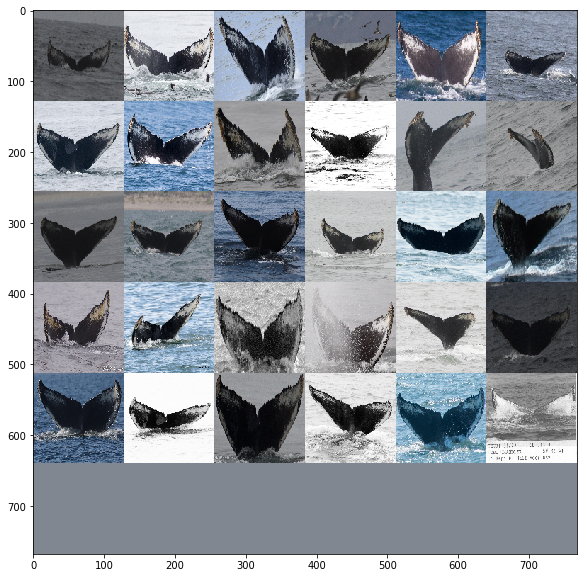

In [7]:
plot_whale_sightings('w_fd6a3ad')

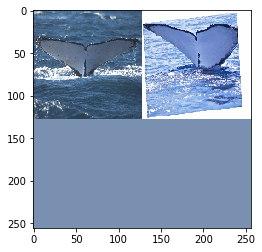

In [8]:
plot_whale_sightings('w_825910b', (4,4))

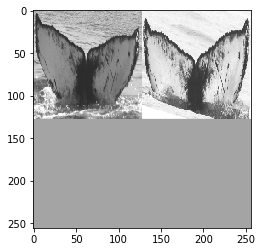

In [9]:
plot_whale_sightings('w_b30acf8', (4,4))

Either we are getting very lucky with picking IDs, or the images for a given whale seem to come from different sightings (or at least they vary to some extent, versus having multiple shots from the same angle).

This could be verified further but for the purposes of creating a validation set on a model that I am not hoping to be the final model that we will train, this should be enough.

In [4]:
im_count.name = 'sighting_count'

In [5]:
df = df.join(im_count, on='Id'); df.head()

,Image,Id,sighting_count
0,0000e88ab.jpg,w_f48451c,14.0
1,0001f9222.jpg,w_c3d896a,4.0
2,00029d126.jpg,w_20df2c5,4.0
3,00050a15a.jpg,new_whale,NaN
4,0005c1ef8.jpg,new_whale,NaN


In [6]:
val_fns = set(df.sample(frac=1)[(df.Id != 'new_whale') & (df.sighting_count > 1)].groupby('Id').first().Image)

/home/radek/anaconda3/envs/fastai_n/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [7]:
# alternate way of constructing the validation set

# val_fns = set()
# for grp in df[df.sighting_count > 1].groupby('Id'):
#     if grp[1].shape[0] < 11: 
#         val_fns = val_fns.union(set([grp[1].sample(frac=1).iloc[0].Image])) # grabbing 1 im when we have under 10 total images of a whale
#     else:
#         val_fns = val_fns.union(set(grp[1].sample(frac=0.1).Image)) # going for ~10% of images where im_count for whale > 10

In [8]:
fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}

In [9]:
SZ = 224
BS = 64
NUM_WORKERS = 12
SEED=0

In [10]:
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)

In [11]:
data = (
    ImageItemList
        .from_df(df[df.Id != 'new_whale'], 'data/train', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(ImageItemList.from_folder('data/test'))
        .transform(get_transforms(do_flip=False, max_zoom=1, max_warp=0, max_rotate=2), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

In [12]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (12766 items)
[Category w_f48451c, Category w_c3d896a, Category w_20df2c5, Category w_dd88965, Category w_581ba42]...
Path: data/train
x: ImageItemList (12766 items)
[Image (3, 700, 1050), Image (3, 325, 758), Image (3, 497, 1050), Image (3, 458, 1050), Image (3, 476, 1050)]...
Path: data/train;

Valid: LabelList
y: CategoryList (2931 items)
[Category w_64404ac, Category w_a6f9d33, Category w_d3b46e7, Category w_2ba6978, Category w_8dddbee]...
Path: data/train
x: ImageItemList (2931 items)
[Image (3, 450, 1050), Image (3, 667, 1000), Image (3, 347, 1050), Image (3, 397, 1050), Image (3, 450, 900)]...
Path: data/train;

Test: LabelList
y: CategoryList (7960 items)
[Category w_f48451c, Category w_f48451c, Category w_f48451c, Category w_f48451c, Category w_f48451c]...
Path: data/train
x: ImageItemList (7960 items)
[Image (3, 525, 1050), Image (3, 695, 2919), Image (3, 450, 1050), Image (3, 450, 1050), Image (3, 360, 1008)]...
Path: data/tr

In [13]:
len(data.classes)

5004

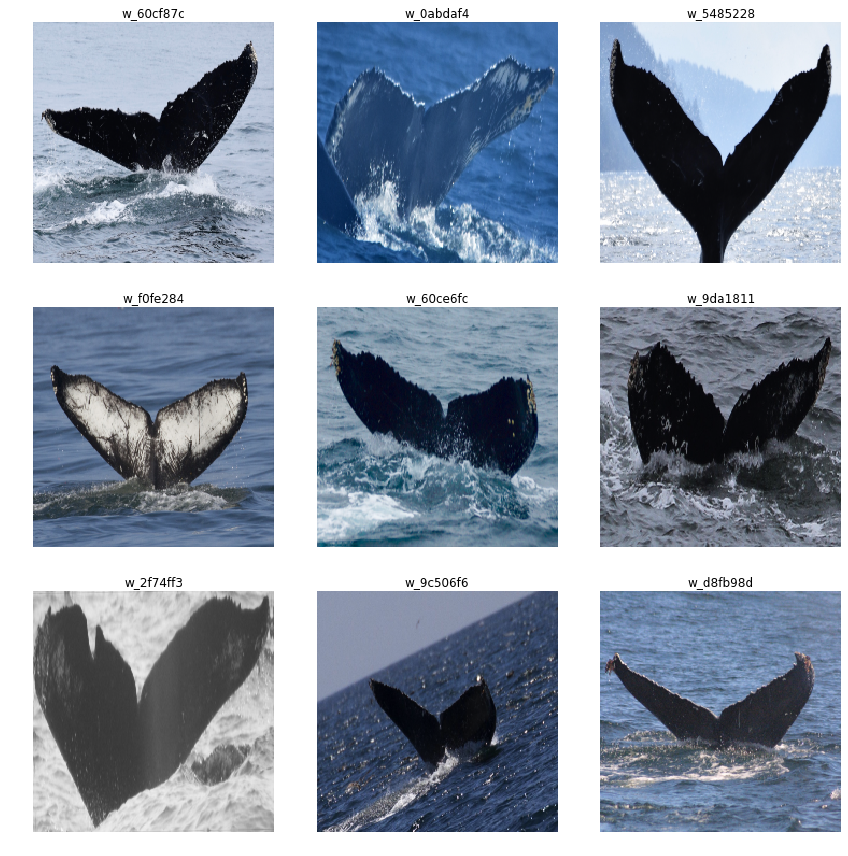

In [14]:
data.show_batch(rows=3)

## Train

In [15]:
name = f'res50-{SZ}'

In [16]:
learn = create_cnn(data, models.resnet50, metrics=[accuracy, map5])

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


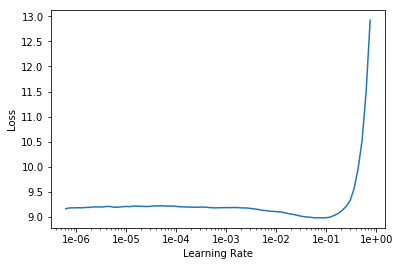

In [24]:
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(6, 1e-2)

epoch,train_loss,valid_loss,accuracy,map5
1,7.621999,8.025841,0.024224,0.033783
2,6.586345,7.447003,0.041283,0.060901
3,5.432683,6.651487,0.084272,0.120101
4,4.286687,5.535724,0.191743,0.233623
5,3.011576,4.777768,0.272944,0.319362
6,1.967255,4.604643,0.300239,0.343791


Why is the train loss so much lower than validation loss? 

In [26]:
learn.save(f'{name}-stage-1')

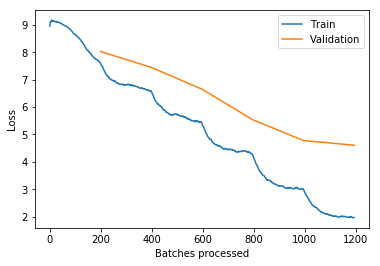

In [27]:
learn.recorder.plot_losses()

In [18]:
learn.unfreeze()

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


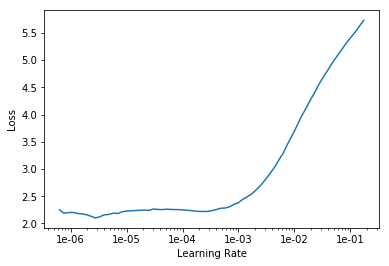

In [20]:
learn.recorder.plot()

In [21]:
max_lr = 1e-4
lrs = [max_lr/100, max_lr/10, max_lr]

In [22]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,accuracy,map5
1,2.212707,2.820541,0.559195,0.608700
2,2.177966,2.823087,0.556124,0.606346
3,2.123407,2.804065,0.558171,0.608200
4,2.091677,2.783767,0.565677,0.612999
5,1.931251,2.756756,0.567042,0.614637
6,1.865603,2.730973,0.569430,0.617457
7,1.750219,2.704931,0.576595,0.623490
8,1.744072,2.698355,0.573183,0.621210
9,1.674739,2.687364,0.574548,0.623541
10,1.611902,2.696755,0.575571,0.623422


In [23]:
learn.save(f'{name}-stage-2')

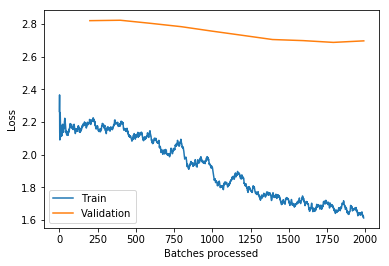

In [24]:
learn.recorder.plot_losses()

Maybe we are underfitting a bit here. Let's see if we can do better by reducing dropout.

In [58]:
learn = create_cnn(data, models.resnet50, metrics=[accuracy, map5], ps=[0.15, 0.3])

In [60]:
learn.unfreeze(); learn.load(f'{name}-stage-2');

In [62]:
learn.fit_one_cycle(6, lrs)

epoch,train_loss,valid_loss,accuracy,map5
1,1.272617,2.675258,0.576595,0.625145
2,1.283733,2.610057,0.588195,0.634237
3,1.174789,2.569288,0.596384,0.644035
4,1.057938,2.529194,0.603207,0.651689
5,0.950911,2.501083,0.611054,0.658029
6,0.940082,2.499051,0.611054,0.657301


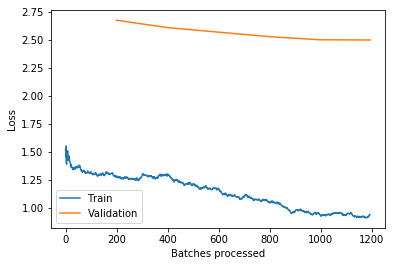

In [65]:
learn.recorder.plot_losses()

In [63]:
learn.save(f'{name}-stage-3')

## Adding new_whale to predictions 

In [83]:
new_whale_fns = set(df[df.Id == 'new_whale'].sample(frac=1).Image.iloc[:1000])

In [129]:
data = (
    ImageItemList
        .from_df(df, 'data/train', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns.union(new_whale_fns))
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=learn.data.classes)
        .add_test(ImageItemList.from_folder('data/test'))
        .transform(get_transforms(do_flip=False, max_zoom=1, max_warp=0, max_rotate=2), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

In [130]:
learn.data = data

In [131]:
preds, _ = learn.get_preds(DatasetType.Valid)

In [141]:
classes = learn.data.classes + ['new_whale']

In [161]:
targs = torch.tensor([classes.index(label.obj) if label else 5004 for label in learn.data.valid_ds.y])

In [162]:
# without predicting new_whale
map5(preds, targs)

tensor(0.4901)

In [133]:
# without predicting new_whale
map5(preds, targs)

tensor(0.4901)

In [175]:
preds = torch.cat((preds, torch.ones_like(preds[:, :1])), 1)

In [177]:
# always predicting new_whale with probability = 1
map5(preds, targs)

tensor(0.5046)

In [191]:
%%time
res = []
ps = np.linspace(0, 1, 51)
for p in ps:
    preds[:, 5004] = p
    res.append(map5(preds, targs).item())

CPU times: user 1min 4s, sys: 2.88 s, total: 1min 7s
Wall time: 1min 7s


In [198]:
best_p = ps[np.argmax(res)]; best_p

0.18

In [199]:
preds[:, 5004] = best_p

In [200]:
map5(preds, targs)

tensor(0.6723)

## Predict

In [202]:
preds, _ = learn.get_preds(DatasetType.Test)

In [203]:
preds = torch.cat((preds, torch.ones_like(preds[:, :1])), 1)

In [204]:
preds[:, 5004] = best_p

In [207]:
create_submission(preds, learn.data, name, classes)

In [208]:
pd.read_csv(f'subs/{name}.csv.gz').head()

,Image,Id
0,47380533f.jpg,w_6c995fd new_whale w_57acd97 w_0b1e4a6 w_05bf34e
1,1d9de38ba.jpg,w_46796cc new_whale w_0027efa w_7b41bf7 w_0b1e4a6
2,b3d4ee916.jpg,new_whale w_f75ed58 w_6e6307e w_bc7de9f w_89f521e
3,460fd63ae.jpg,new_whale w_90c9763 w_9bd2794 w_a9304b9 w_b86917d
4,79738ffc1.jpg,new_whale w_e12b78d w_d573a68 w_cdc4a40 w_b938e96


In [209]:
!kaggle competitions submit -c humpback-whale-identification -f subs/{name}.csv.gz -m "{name}"

100%|████████████████████████████████████████| 161k/161k [00:03<00:00, 48.4kB/s]
Successfully submitted to Humpback Whale Identification